<a href="https://colab.research.google.com/github/jpthirumalai/aiml/blob/master/CheXnet_TF_Pneumonia_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
# use the link for TPU troubleshooting https://cloud.google.com/tpu/docs/troubleshooting

Device: grpc://10.58.142.186:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.58.142.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.58.142.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


In [3]:
print(tf.__version__)

2.2.0


In [4]:
#drive.flush_and_unmount()

In [5]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
#check present working directory
cwd = !pwd
print("Current folder: ",cwd)
# %cd '/content/drive/My Drive/AIML/AI/rsnadata/'  #changing as mount subfolder causing issue AIML/AI/rsnadata/
%cd '/content/drive/My Drive'
cwd = !pwd
print("Current working directory after seting proj folder: ",cwd)

Current folder:  ['/content']
/content/drive/My Drive
Current working directory after seting proj folder:  ['/content/drive/My Drive']


In [8]:
from google.colab import auth
auth.authenticate_user()
project_id = 'thirumlai'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://thirumlai/


In [9]:
import keras

Using TensorFlow backend.


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_PATH = 'gs://thirumlai'       #cwd[0] #/content/drive/My Drive
IMAGE_SIZE = [320, 320]
EPOCHS = 25

In [11]:
GCS_PATH

'gs://thirumlai'

In [12]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/positive/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH +'/normal/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [13]:
len(filenames)

26151

In [14]:
print('trainset size {} and validation test size {}'.format(len(train_filenames),len(val_filenames)))

trainset size 20920 and validation test size 5231


In [15]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "positive" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))
# Normal images count in training set: 16205
# Pneumonia images count in training set: 4716

Normal images count in training set: 16227
Pneumonia images count in training set: 4693


In [16]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'gs://thirumlai/normal/8672529d-7b85-4c2d-b9b0-6ecb13954d2d.png'
b'gs://thirumlai/normal/e6604726-421a-4e45-a3cf-23efa8b54206.png'
b'gs://thirumlai/normal/548b0ce7-2797-4d24-814e-d419d2e82fb6.png'
b'gs://thirumlai/normal/5638cc31-f018-4701-a668-b98eac35a0b8.png'
b'gs://thirumlai/normal/a571f93c-e682-4b6f-801c-7cb4be89cee0.png'


In [17]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 20920
Validating images count: 5231


In [18]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "positive"

In [19]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [20]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [21]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [22]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (320, 320, 3)
Label:  False


In [23]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [24]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [25]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

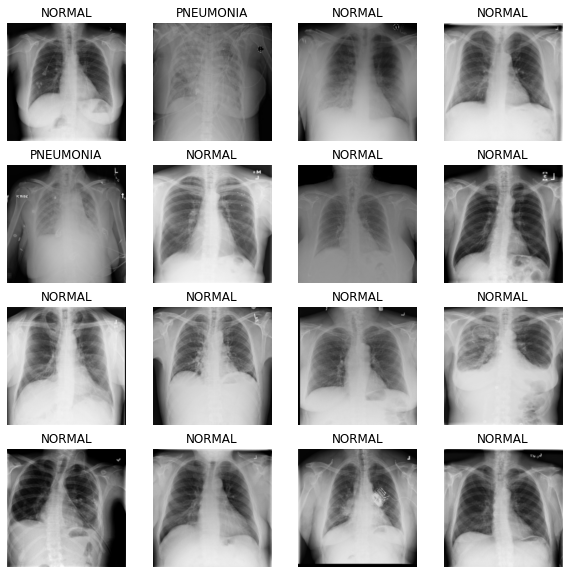

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [27]:
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras import Model

In [28]:
def build_model():
  base_model = DenseNet121(include_top=False, weights=None, input_shape=(320, 320, 3))
  base_model_out = base_model.output
  pooling_layer = GlobalAveragePooling2D(name='pooling_layer')(base_model_out)
  output = Dense(units=14, activation='softmax', name='output_layer')(pooling_layer)
  chexnet_model = Model(inputs=base_model.input, outputs=output)
  return chexnet_model

In [29]:
chexnet_model = build_model()

In [30]:
chexnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [31]:
# !gsutil -m cp gs://thirumlai/chexnet_wt/CheXNet_v0.3.0.h5  /content/drive/My\ Drive/AIML/AI/chexnet 

In [32]:
# !pwd

In [33]:
chexnet_model.load_weights('/content/drive/My Drive/AIML/AI/chexnet')

In [34]:
chexnet_model.compile(optimizer='adam', loss='binary_crossentropy')

In [35]:
test_image = image_batch[10]
label = label_batch[10]
print(label)

tf.Tensor(False, shape=(), dtype=bool)


In [36]:
print('sample prediction: \n', chexnet_model.predict(np.expand_dims(test_image, axis=0)))

sample prediction: 
 [[7.3422164e-02 7.0132671e-07 3.2035857e-02 8.8169765e-01 1.2359448e-03
  4.2984504e-03 4.1645901e-05 1.5526989e-03 5.3384337e-03 2.2292124e-05
  1.2146006e-05 9.8187975e-06 3.3214633e-04 2.9433039e-11]]


14 classes <br>
<hr>
1,Atelectasis <br>
2,Cardiomegaly <br>
3,Effusion <br>
4,Infiltration <br>
5,Mass <br>
6,Nodule <br>
7,Pneumonia <br>
8,Pneumothorax <br>
9,Consolidation <br>
10,Edema <br>
11,Emphysema <br>
12,Fibrosis <br>
13,Pleural Thickening <br>
14,Hernia <br>

In [37]:
# !pip install lime

In [38]:
def generate_explanation(model, input_image):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image=input_image, classifier_fn=model.predict, hide_color=0,
                                             num_samples=1000, random_seed=18)
    temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0], positive_only=True, num_features=5,
                                                hide_rest=False)
    return temp, mask

In [39]:
from keras.preprocessing.image import load_img, img_to_array
import cv2.cv2 as cv2, numpy as np

In [40]:
IMG_PATH = ['positive/0550968f-5ad7-460c-96c5-c2702535e344.jpg', '0']
IMG_SHAPE = (320, 320, 3)

In [41]:
test_img = load_img(path=IMG_PATH[0], color_mode='grayscale')
test_img = img_to_array(img=test_img, data_format='channels_last')
test_img = cv2.resize(test_img, dsize=IMG_SHAPE[:2], interpolation=cv2.INTER_NEAREST)
test_img = np.expand_dims(test_img, axis=-1)
test_img = test_img.astype(np.uint8)
test_img = test_img / 255.
test_img = np.concatenate((test_img, test_img, test_img), axis=-1)
print('external image(s) shape:', test_img.shape)

external image(s) shape: (320, 320, 3)


In [42]:
# generate_explanation(chexnet_model,test_img)

In [43]:
t1_result = chexnet_model.predict(np.expand_dims(test_img, axis=0))
print('sample prediction: \n', t1_result)

sample prediction: 
 [[1.0492774e-01 5.4509218e-07 4.9807791e-02 8.3336979e-01 7.5729203e-04
  1.7886399e-03 4.0318308e-05 5.8943045e-04 8.5002044e-03 2.5235437e-05
  3.7853499e-06 4.0894743e-06 1.8517472e-04 4.6530692e-11]]


In [44]:
# test CheXNet accuracy and imaging features on sample cases

def plot_image(dimage, realabel,dresult):
  fig1 = plt.figure(num=7, figsize=(21, 9))

  plt.subplot(3, 7, 1)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Atelectasis=%.4f' % dresult[0][0])

  plt.subplot(3, 7, 2)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Cardiomegaly=%.4f' % dresult[0][1])

  plt.subplot(3, 7, 3)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Effusion=%.4f' % dresult[0][2])


  plt.subplot(3, 7, 4)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Infiltration=%.4f' % dresult[0][3])


  plt.subplot(3, 7, 5)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Mass=%.4f' % dresult[0][4])

  plt.subplot(3, 7, 6)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Nodule=%.4f' % dresult[0][5])


  plt.subplot(3, 7, 7)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Pneumonia=%.4f' % dresult[0][6])

  plt.subplot(3, 7, 8)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Pneumothorax=%.4f' % dresult[0][7])

  plt.subplot(3, 7, 9)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Consolidation=%.4f' % dresult[0][8])

  plt.subplot(3, 7, 10)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Edema=%.4f' % dresult[0][9])

  plt.subplot(3, 7, 11)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Emphysema=%.4f' % dresult[0][10])

  plt.subplot(3, 7, 12)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Fibrosis=%.4f' % dresult[0][11])

  plt.subplot(3, 7, 13)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Pleural Thickening=%.4f' % dresult[0][12])

  plt.subplot(3, 7, 14)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('Hernia=%.4f' % dresult[0][13])

  plt.subplot(3, 7, 15)
  plt.imshow(dimage, cmap='gray')
  plt.axis('off')
  plt.title('label=%s' % realabel)

  plt.show()
  print('all classes probabilities:')
  print(dresult)
  # fig1.savefig(fname='/content/drive/My Drive/chexnet_ex.png')

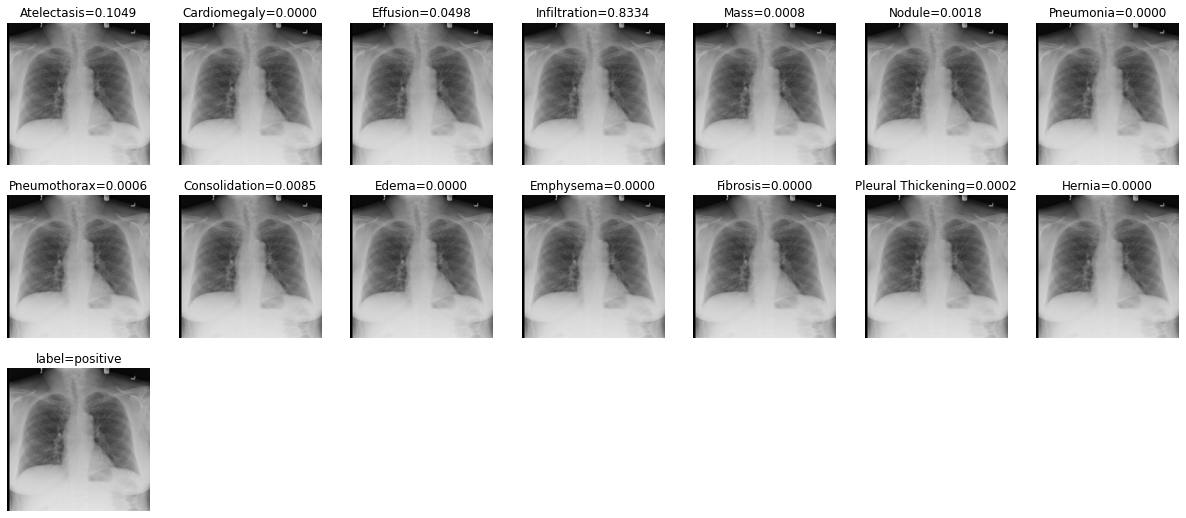

all classes probabilities:
[[1.0492774e-01 5.4509218e-07 4.9807791e-02 8.3336979e-01 7.5729203e-04
  1.7886399e-03 4.0318308e-05 5.8943045e-04 8.5002044e-03 2.5235437e-05
  3.7853499e-06 4.0894743e-06 1.8517472e-04 4.6530692e-11]]


In [45]:
plot_image(test_image,'positive',t1_result)

In [46]:
t2_img = image_batch[2]
label = label_batch[2]
print(label)

tf.Tensor(False, shape=(), dtype=bool)


In [47]:
t2_result = chexnet_model.predict(np.expand_dims(t2_img, axis=0))

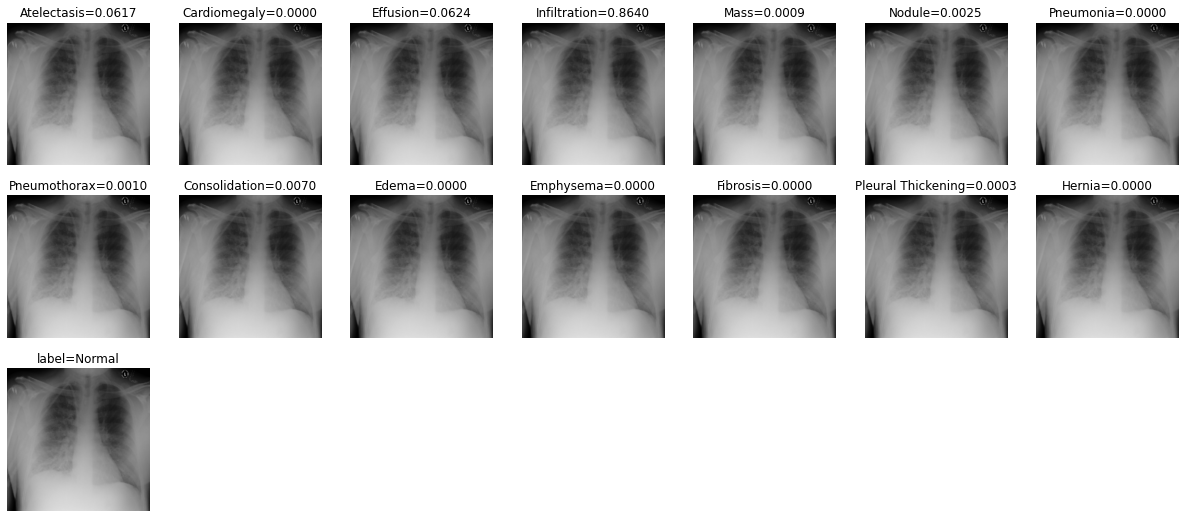

all classes probabilities:
[[6.1691590e-02 5.0296848e-07 6.2398102e-02 8.6404127e-01 9.4209431e-04
  2.5099861e-03 4.4791679e-05 9.6890843e-04 7.0365500e-03 3.2153624e-05
  4.7069279e-06 6.6801645e-06 3.2267129e-04 1.6133799e-11]]


In [48]:
plot_image(t2_img,'Normal',t2_result)

In [49]:
t3_img = image_batch[5]
label = label_batch[5]
print(label)

tf.Tensor(False, shape=(), dtype=bool)


In [50]:
t3_result = chexnet_model.predict(np.expand_dims(t3_img, axis=0))

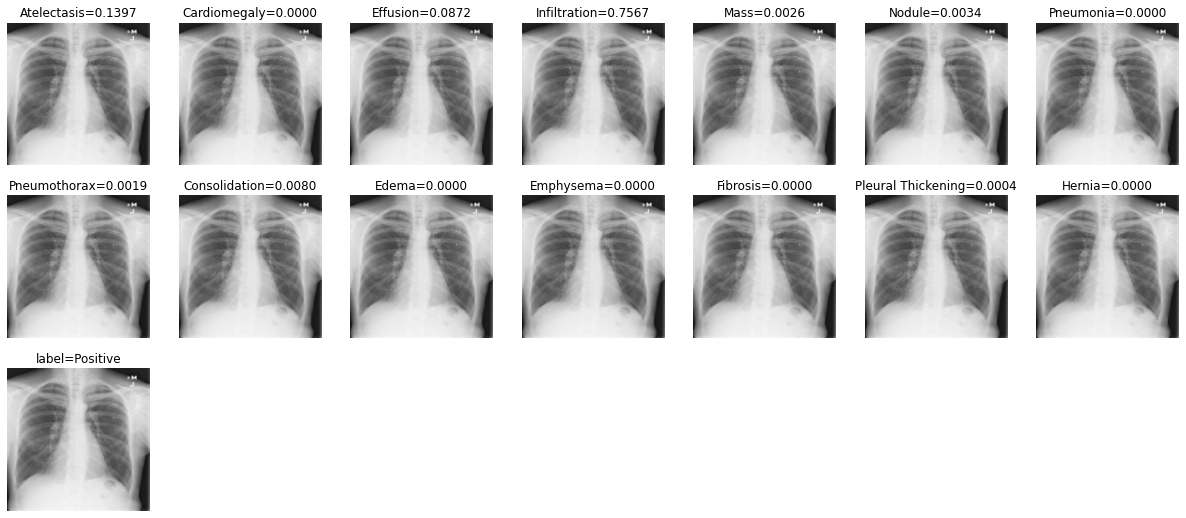

all classes probabilities:
[[1.3970836e-01 7.2461802e-07 8.7212041e-02 7.5667512e-01 2.6181806e-03
  3.4447908e-03 4.8426740e-05 1.9219997e-03 7.9568774e-03 2.3227383e-05
  1.4159846e-05 1.2362103e-05 3.6368996e-04 4.3599249e-11]]


In [51]:
plot_image(t3_img,'Positive',t3_result)

In [52]:
test_image_batch, test_label_batch = next(iter(val_ds))

In [53]:
test_label_batch

<tf.Tensor: shape=(128,), dtype=bool, numpy=
array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
        True, False, False, False,  True, False, False,  True, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False,  True, False,  True,
        True, False,  True,  True, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
        True,  True, False, False,  True,  True, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False,  True,  True,  True,
       False,  True, False,  True, False, Fal

In [54]:
tst1_img = test_image_batch[4]
label = test_label_batch[4]
print(label)

tf.Tensor(False, shape=(), dtype=bool)


In [55]:
tst1_result = chexnet_model.predict(np.expand_dims(tst1_img, axis=0))

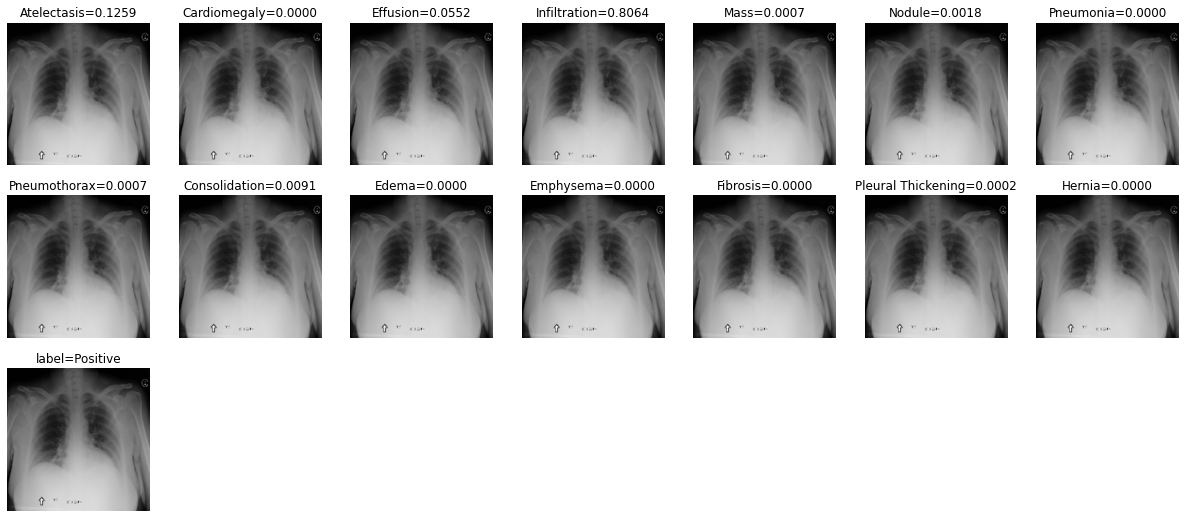

all classes probabilities:
[[1.2591302e-01 1.1247452e-06 5.5196609e-02 8.0641681e-01 7.2451372e-04
  1.7551008e-03 4.8442002e-05 6.5881968e-04 9.0510808e-03 3.7863709e-05
  4.9914383e-06 5.0072003e-06 1.8666200e-04 3.1422937e-11]]


In [56]:
plot_image(tst1_img,'Positive',tst1_result)

In [57]:
tst2_img = test_image_batch[2]
label = test_label_batch[2]
print(label)

tf.Tensor(False, shape=(), dtype=bool)


In [58]:
tst2_result = chexnet_model.predict(np.expand_dims(tst2_img, axis=0))

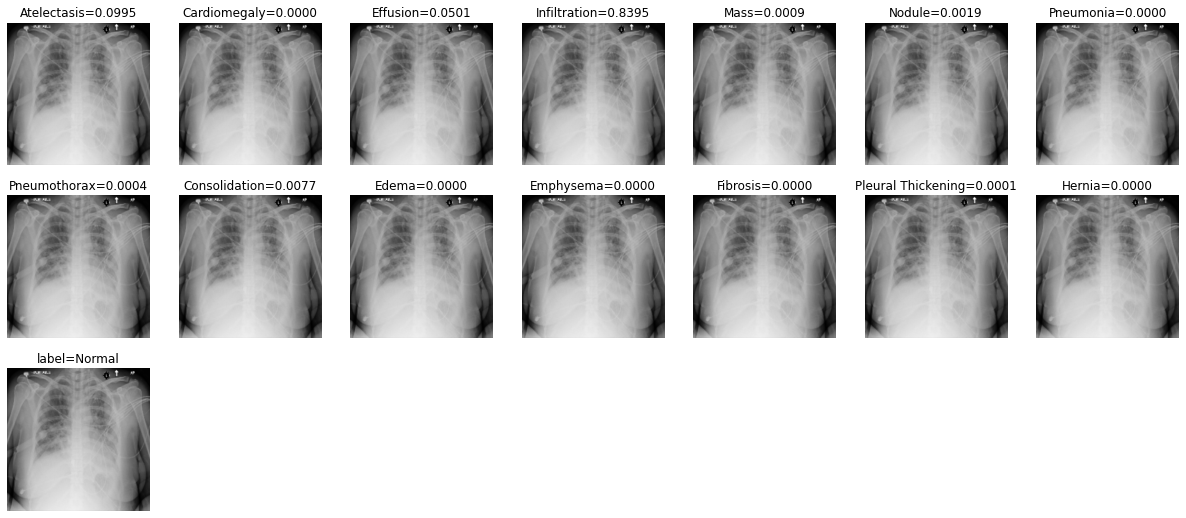

all classes probabilities:
[[9.9457346e-02 5.3552964e-07 5.0115760e-02 8.3952361e-01 8.5919094e-04
  1.8596546e-03 3.9789251e-05 3.5092013e-04 7.6594478e-03 3.3120163e-05
  5.2824689e-06 2.4147294e-06 9.2953371e-05 1.8674489e-11]]


In [59]:
plot_image(tst2_img,'Normal',tst2_result)